<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Granger Causality

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot
import scipy
from statsmodels.tsa.stattools import adfuller
from functools import reduce

from scipy import stats

## **Create & Analyse Financial Series**

In [0]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
series = pd.read_csv(url)
series = series.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
series = series.set_index('Date')

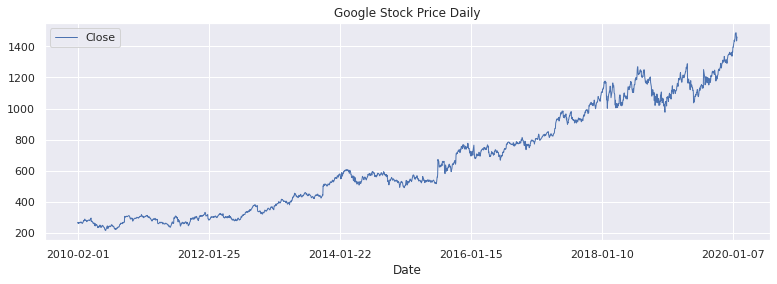

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
series.plot(linewidth=1.0,title='Google Stock Price Daily')

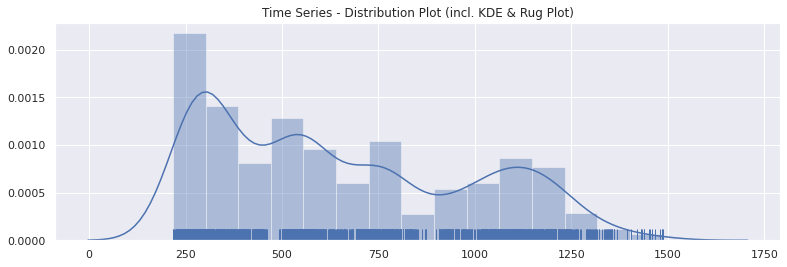

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((series), hist=True, rug=True).set_title('Time Series - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

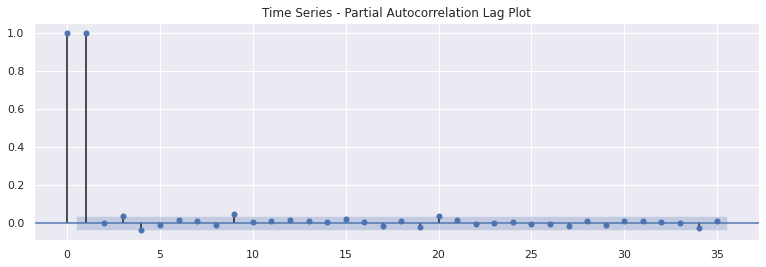

In [0]:
plot_pacf(series)
plt.title('Time Series - Partial Autocorrelation Lag Plot')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


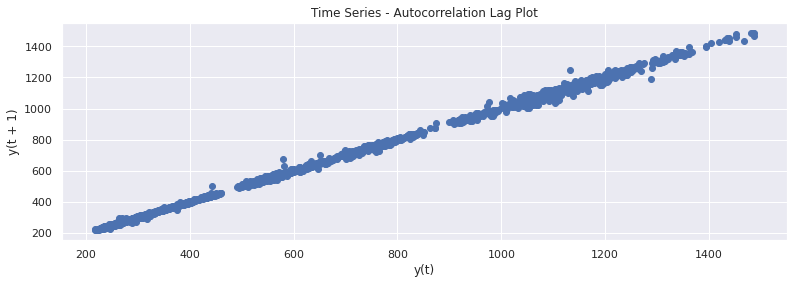

In [0]:
lag_plot(series)
plt.title('Time Series - Autocorrelation Lag Plot')
plt.show()

## **Create & Analyse Lagged Series**

To test a very clear causal relationship, let's add a lag t-1 to the financial time series and test them for Granger causality. Since there is a clear autocorrelation in t-1 as outlined above, the Granger causality test should be positive.

In [0]:
series = concat([series.shift(1), series], axis=1)
series.columns = ['present', 'past']
series = series.dropna()
print(series.head(5))

               present        past
Date                              
2010-02-02  265.514771  264.568329
2010-02-03  264.568329  269.400208
2010-02-04  269.400208  262.406433
2010-02-05  262.406433  264.653015
2010-02-08  264.653015  265.738953


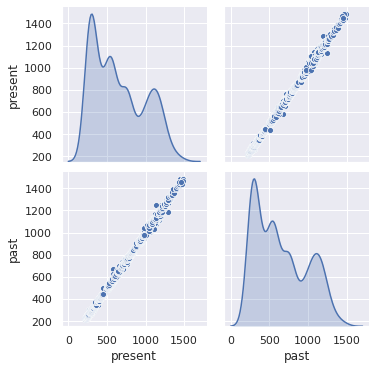

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.pairplot(series, diag_kind='kde')

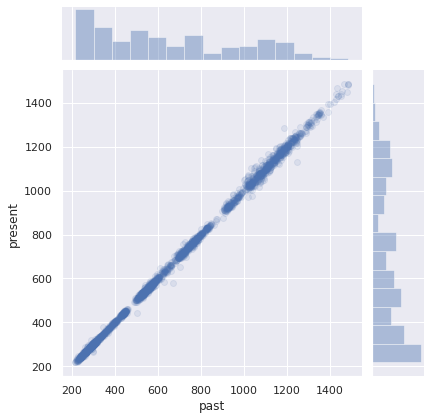

In [0]:
sns.jointplot(x="past", y="present", data=series, alpha=0.1);

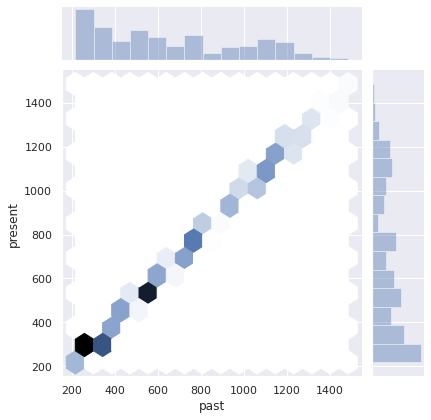

In [0]:
sns.jointplot(x="past", y="present", data=series, kind="hex");

Text(0.5, 0, 'record number')

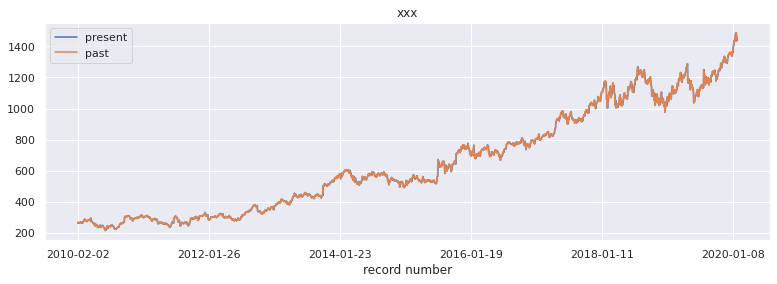

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
series.plot(linewidth=1.5,title='xxx')
plt.xlabel('record number')

# **Stationarity Test & Transform**

Granger causality (1969) requires both series to be stationary, so let's test whether this is true for both time series, and difference them until they are stationary.

## **Stationarity & Difference (Past)**

In [0]:
# Augmented Dicker Fuller test
# H0: There is a unit root for the series (non stationary). Reject H0 if p-value of less than 5% 
# no constant, no trend
statsmodels.tsa.stattools.adfuller(series.past, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(2.9203780191829734,
 0.9997075998411147,
 20,
 2494,
 {'1%': -2.566637054647272,
  '10%': -1.616713939107425,
  '5%': -1.941108237457268},
 18859.519137810224)

p-value above 0.05. Not reject H0. Series is not stationary Transformation for Granger test required (difference time series).

In [0]:
# Difference series
data = series.past
differenced_past = (data - data.shift(1))
differenced_past = differenced_past.dropna()

In [0]:
statsmodels.tsa.stattools.adfuller(differenced_past, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-11.307906843205679,
 1.672093316997256e-20,
 17,
 2496,
 {'1%': -2.5666363353866184,
  '10%': -1.616714023745387,
  '5%': -1.9411081502986165},
 18858.655293548058)

Past series is now stationary. They have been a unit root before, since it had to be differenced once only.

## **Stationarity & Difference (Present)**

In [0]:
statsmodels.tsa.stattools.adfuller(series.present, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(2.9180072584443,
 0.9997040665808604,
 20,
 2494,
 {'1%': -2.566637054647272,
  '10%': -1.616713939107425,
  '5%': -1.941108237457268},
 18859.505835476455)

p-value above 0.05. Not reject H0. Series is not stationary Transformation for Granger test required (difference time series).

In [0]:
# Difference series
data = series.present
differenced_present = (data - data.shift(1))
differenced_present = differenced_present.dropna()

In [0]:
statsmodels.tsa.stattools.adfuller(differenced_present, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-11.300247000508126,
 1.7331869542573804e-20,
 17,
 2496,
 {'1%': -2.5666363353866184,
  '10%': -1.616714023745387,
  '5%': -1.9411081502986165},
 18859.171083336038)

Past series is now stationary. They have been a unit root before, since it had to be differenced once only.

## **Merge Series**

In [0]:
# Create lagged dataset
series = concat([differenced_present, differenced_past], axis=1)
series = series.dropna()
print(series.head(5))

             present      past
Date                          
2010-02-03 -0.946442  4.831879
2010-02-04  4.831879 -6.993775
2010-02-05 -6.993775  2.246582
2010-02-08  2.246582  1.085938
2010-02-09  1.085938  1.479461


# **Causality Test**

## **Johansen Cointegration**

* H0 is no cointegration. 
* If two time series, X and Y, are cointegrated, there must exist Granger causality either from X to Y, or from Y to X, both in both directions.
* However the presence of Granger causality in either or both directions between X and Y does not necessarily imply that the series will be cointegrated.

In [0]:
statsmodels.tsa.stattools.coint(series.past, series.present, trend='ct', method='aeg', autolag='aic')

(-11.759236707181113,
 2.1109239030380693e-21,
 array([-4.33376918, -3.78435647, -3.49912914]))

Very small p-value. Reject H0. Cointegration present. Granger causality must exit.

## **Granger Causality Test**

* Granger causality require stationary data and data in same scale (or normalized) (Granger causality (1969) requires both series to be stationary. Toda-Yamamoto causality requies no such criteria, the test can be applied to both stationary and non stationary data.)
* Granger causality cannot take into account third hidden factors affecting both series
* Granger can also not differentiate no-linear relationships

In [0]:
# Granger Causality
# Null hypothesis: x2 does NOT Granger cause x1
# Reject null hypothesis if the p-values are below 0.05
statsmodels.tsa.stattools.grangercausalitytests(series, maxlag = 5, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=41969480120691292350977445044682752.0000, p=0.0000  , df_denom=2510, df_num=1
ssr based chi2 test:   chi2=42019642845935146386045926056656896.0000, p=0.0000  , df=1
likelihood ratio test: chi2=180670.1566, p=0.0000  , df=1
parameter F test:         F=41969480120691273904233371335131136.0000, p=0.0000  , df_denom=2510, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2966341848612780914735734878896128.0000, p=0.0000  , df_denom=2508, df_num=2
ssr based chi2 test:   chi2=5942145712691631103806566987464704.0000, p=0.0000  , df=2
likelihood ratio test: chi2=175685.6221, p=0.0000  , df=2
parameter F test:         F=2966726454371939915201732379934720.0000, p=0.0000  , df_denom=2508, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3632047447045335157227521820327936.0000, p=0.0000  , df_denom=2506, df_num=3
ssr based chi2 test:   chi2=109178824495580651

{1: ({'lrtest': (180670.15658300096, 0.0, 1),
   'params_ftest': (4.196948012069127e+34, 0.0, 2510.0, 1.0),
   'ssr_chi2test': (4.201964284593515e+34, 0.0, 1),
   'ssr_ftest': (4.196948012069129e+34, 0.0, 2510.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (175685.62212722193, 0.0, 2),
   'params_ftest': (2.96672645437194e+33, 0.0, 2508.0, 2.0),
   'ssr_chi2test': (5.942145712691631e+33, 0.0, 2),
   'ssr_ftest': (2.966341848612781e+33, 0.0, 2508.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (177144.20437691692, 0.0, 3),
   'params_ftest': (3.646832785571936e+33, 0.0, 2506.0, 3.0),
   'ssr_chi2test': (1.0917882449558065e+34, 0.0, 3),
   'ssr_ftest': (3.632047447045335e+33, 0.0, 2506.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])]),
 4: ({'lrtest': (178412.88428063513, 0.0, 4),
   'params_ftest': (4.660422454501896e+33, 0.0, 2504.0, 4.0),
   'ssr_chi2test':